# Kommasetzung by Till Nöllgen

With this little program we try to predict at which positions in any kind of german text there is a comma. 
For this we use a LSTM network that we train with random free available german books online. In the hope that they properly use the comma rules. For better readablility I wrote the program in this jupyter notebook, because it lets me combine text and code in the same sheet as well print out preliminary statuses. The project was inspired from previouse code from Udacity's Deep Learning Nanodegree and variouse scientific papers about sentiment analysis and word2vec - research.

In [1]:
import os
import io
import csv
import sys
import time
import re
import string
from collections import Counter
import numpy as np
import tensorflow as tf
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Make sure to use Tensorflow 1.0.x

In [2]:
print(tf.VERSION)

1.0.1


# Load dataset
Data set is made out of 12 online free available books (Like for example "Harry Potter - Der Stein der Weisen")

In [3]:
with open('wikiextractor/text/books/untitled.txt', "r", encoding="utf-8") as text:
    text = text.read()
    
### Posibility to shrink down dataset for faster processing if wanted!!!
text = text[:]

#Minimal dataset cleaning by removing the page numbers as well single standing words 
text = re.sub(r'\n[0-9]+ \n', '', text)
text = re.sub(r'\n\n[a-zA-Z] \n\n', '', text)

print(text[:100])

Die beiden schweren Koffer bereiteten meinen Armen ziemliche Schmerzen. Doch da musste ich ab jetzt 


# Tokenizing into words

In [4]:
#TOKENIZING INTO WORDS
from nltk.tokenize import word_tokenize

woerter = word_tokenize(text)
print(woerter[:50])

['Die', 'beiden', 'schweren', 'Koffer', 'bereiteten', 'meinen', 'Armen', 'ziemliche', 'Schmerzen', '.', 'Doch', 'da', 'musste', 'ich', 'ab', 'jetzt', 'durch', '.', 'Von', 'nun', 'an', 'würde', 'mir', 'keiner', 'mehr', 'die', 'Sachen', 'abnehmen', 'oder', 'mir', 'ein', 'schönes', ',', 'heißes', 'Bad', 'vorbereiten', '.', 'Mein', 'Vater', 'war', 'ein', 'sehr', 'reicher', 'Geschäftsmann', ',', 'der', 'gerade', 'ein-', 'bis', 'zweimal']


# Stemming

In [5]:
#STEMMING
x = (len(set(woerter)))
sno = nltk.stem.SnowballStemmer('german')
woerter_stem = [sno.stem(wort) for wort in woerter]
y = (len(set(woerter_stem)))

print(str((x-y)*100/(x)) +" percent of the words saved by using stemming")

33.27540895682488 percent of the words saved by using stemming


In [6]:
counts = Counter(woerter_stem)
print(counts.most_common(20))

[(',', 141610), ('.', 111046), ('und', 55578), ('ich', 48683), ('ein', 37482), ('sie', 36688), ('die', 36262), ("''", 29468), ('er', 28399), ('nicht', 27751), ('war', 27207), ('“', 27125), ('``', 26733), ('das', 25415), ('es', 24126), ('der', 23629), ('zu', 23205), ('in', 22672), ('?', 20957), ('ihr', 18608)]


Actually here you can see how many commas are in the training data. Normally it is around every 10th word...

# Part of speech 

In this project the "TIGER Corpus Release 2.1" of the university Stuttgart was used. Make sure to adjust the root of the corpus depending where it is safed (unzipped 60 MB)

http://www.ims.uni-stuttgart.de/forschung/ressourcen/korpora/TIGERCorpus/download/start.html

https://datascience.blog.wzb.eu/2016/07/13/accurate-part-of-speech-tagging-of-german-texts-with-nltk/



In [7]:
# GERMAN WORD CLASSES / LEXICAL CATEGORIES
from ClassifierBasedGermanTagger.ClassifierBasedGermanTagger import ClassifierBasedGermanTagger
#from nltk.tag import UnigramTagger

'''
    WORDS = 'words'   #: column type for words
    POS = 'pos'       #: column type for part-of-speech tags
    TREE = 'tree'     #: column type for parse trees
    CHUNK = 'chunk'   #: column type for chunk structures
    NE = 'ne'         #: column type for named entities
    SRL = 'srl'       #: column type for semantic role labels
    IGNORE = 'ignore' #: column type for column that should be ignored

    #: A list of all column types supported by the conll corpus reader.
    COLUMN_TYPES = (WORDS, POS, TREE, CHUNK, NE, SRL, IGNORE)
'''
#Choose the root 
root = '/output/' #For a server like FloydHub
#root = '/Users/Till/Dropbox/Deep Learning Udacity/deep-learning/KommasetzungAusweichordner'
fileid = 'tiger_release_aug07.corrected.16012013.conll09'
columntypes = ['ignore', 'words', 'ignore', 'ignore', 'pos']

#Load corpus
corp = nltk.corpus.ConllCorpusReader(root, fileid, columntypes, encoding='utf8')

#Train on whole corpus (normally it has a accuracy around 94% - 96% depending on text)
tagger = ClassifierBasedGermanTagger(train=corp.tagged_sents())
#tagger = UnigramTagger(corp.tagged_sents())

In [8]:
#Part of speech tagging on data set
idx = int(len(woerter)*1.0)
w_classes = tagger.tag(woerter[:idx])

In [9]:
print(w_classes[:10])

[('Die', 'ART'), ('beiden', 'PIAT'), ('schweren', 'ADJA'), ('Koffer', 'NN'), ('bereiteten', 'VVFIN'), ('meinen', 'PPOSAT'), ('Armen', 'NN'), ('ziemliche', 'VVFIN'), ('Schmerzen', 'NN'), ('.', '$.')]


In [10]:
woerter_classes = []

for word in w_classes:
    if "$" in str(word[1]):
        word_class = word[0] + "c"
    else:
        word_class = word[1]
    woerter_classes.append(word_class)

In [11]:
print(woerter_classes[:30])

['ART', 'PIAT', 'ADJA', 'NN', 'VVFIN', 'PPOSAT', 'NN', 'VVFIN', 'NN', '.c', 'KON', 'KOUS', 'PIS', 'PPER', 'PTKVZ', 'ADV', 'APPR', '.c', 'APPR', 'ADV', 'APPR', 'VAFIN', 'PPER', 'PIS', 'ADV', 'ART', 'NN', 'VVINF', 'KON', 'PPER']


# Transform words into numbers

In [12]:
vocab = sorted(counts, key=counts.get, reverse=True)

counts_classes = Counter(woerter_classes)
vocab_classes = sorted(counts_classes, key=counts_classes.get, reverse=True)

vocabs = vocab + vocab_classes
print(str(len(vocabs)) +" unique words/lemmas in the lookup table")

vocabs_to_int = {wort: i for i, wort in enumerate(vocabs, 1)}
int_to_vocabs = {wort: i for i, wort in vocabs_to_int.items()}

# Add "None" key for later unknown words
i = len(int_to_vocabs)+1
w = int_to_vocabs[i]

del vocabs_to_int[w]
vocabs_to_int["None"] = i

int_to_vocabs[i] = "None"

62341 unique words/lemmas in the lookup table


In [13]:
print(len(vocabs_to_int))
print(int_to_vocabs[62341])
print(int_to_vocabs[62340])

print(vocabs_to_int["None"])


62340
None
-Bittec
62341


# Setting labels

If word is a comma, then the label is "1" otherwise "0"

In [14]:
labels = []
#for idx, wort in enumerate(woerter,0):
for wort in woerter:
    if wort == ",":
        labels.append(1)
        #labels.append([1, wort])
    else:
        labels.append(0)
        #labels.append([0, wort])    

print(labels[:40])
print(woerter[:40])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
['Die', 'beiden', 'schweren', 'Koffer', 'bereiteten', 'meinen', 'Armen', 'ziemliche', 'Schmerzen', '.', 'Doch', 'da', 'musste', 'ich', 'ab', 'jetzt', 'durch', '.', 'Von', 'nun', 'an', 'würde', 'mir', 'keiner', 'mehr', 'die', 'Sachen', 'abnehmen', 'oder', 'mir', 'ein', 'schönes', ',', 'heißes', 'Bad', 'vorbereiten', '.', 'Mein', 'Vater', 'war']


# Removing Commas
Let's remove comma placeholder in the labels and the text: That means a word after a comma now will become the label "1" instead of "0" and one "0" will be removed as well as all comma and comma synonyms will be removed.

In [15]:
labels_indicator = np.roll(labels, 1)
labels = [labels[i] for i in range(0,len(labels)) if labels_indicator[i] != 1]
labels = np.asarray(labels)

woerter = [woerter[i] if labels_indicator[i] != 1 else (", " + woerter[i]) for i in range(0,len(woerter))]
woerter = [wort for wort in woerter if wort!= ","]
woerter_stem = [wort for wort in woerter_stem if wort!= ","]
woerter_classes = [wort for wort in woerter_classes if wort!= ",c"]

# Transform text to numbers

In [16]:
woerter_ints = [vocabs_to_int[wort] if wort in vocabs_to_int else vocabs_to_int["None"] for wort in woerter_stem]
woerter_classes_ints= [vocabs_to_int[wort] if wort in vocabs_to_int else vocabs_to_int["None"] for wort in woerter_classes]

print(woerter_ints[:10])
print(woerter_classes_ints[:10])

[7, 145, 360, 1130, 2087, 25, 146, 341, 419, 2]
[62209, 62227, 62216, 62205, 62210, 62218, 62205, 62210, 62205, 62212]


# Making features

### So what the function actually does:

You feed in the index of the word and get out a list of 20 digits (depends on the window size). The first ten digits are the ten stemmed words behind the index-word/comma. The second ten digits are the same ten words behind the index-word/comma but representing the word classification (also know as Lemmatization). In the beginning I also experimented by feeding in words that stand in front of the index-word/comma. But actually the network already has "seen" those words and "interpreted" the most important informations of it (by the way a LSTM-network works). I also experimented with randomizing the window size based on a idea of [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf) (word to vector research). But no positive effect could be seen, so I simplified it again.

In [17]:
def get_batch(woerter_ints, idx, window_size=10): # woerter_ints should be woerter_ints or woerter_classes_ints 
                                  
    
    #r = np.random.randint(5, window_size+1)
    r = window_size
    
    
    #lower Boundaries for the beginning of the data set
    if idx - r < 0:
        minus_idx = 0
    else:
        minus_idx = idx - r
        
    #upper Boundaries for the ending of the data set   
    if idx + r > len(woerter_ints):
        plus_idx = len(woerter_ints)
    else:
        plus_idx = idx + r
        
        
    davor = woerter_ints[minus_idx:idx]
    danach = woerter_ints[idx:plus_idx]
    
    
    #Cut of at a fullstop (Isolate sentences)
    for ii in range(0,len(davor)):
        if davor[ii] == vocabs_to_int["."] or davor[ii] == vocabs_to_int[".c"]:
            davor = davor[ii+1:]
            break
    
    for ii in range(0,len(danach)):
        if danach[ii] == vocabs_to_int["."] or danach[ii] == vocabs_to_int[".c"]:
            danach = danach[:ii+1]
            break
    
    
    x_davor = ([0]*(window_size-len(davor))) + davor
    x_danach = danach + ([0]*(window_size-len(danach)))
    
    x = x_davor + x_danach
    #x = x_danach
    
    return x
        

In [18]:
features = []
feature_woerter = [get_batch(woerter_ints, idx, window_size=10) for idx in range(0,len(labels))]
feature_classes =  [get_batch(woerter_classes_ints, idx, window_size=10) for idx in range(0,len(labels))]
features = list(zip(feature_woerter, feature_classes))
features = np.asarray(features).reshape(len(labels), -1)

print(features.shape)

(2135101, 40)


In [19]:
print(woerter[20:30])
print(features[20:30])

['an', 'würde', 'mir', 'keiner', 'mehr', 'die', 'Sachen', 'abnehmen', 'oder', 'mir']
[[    0     0     0     0     0     0     0     0    37   125    36    38
     31    62    71     7   388  6781    70    31     0     0     0     0
      0     0     0     0 62211 62207 62211 62213 62206 62231 62207 62209
  62205 62219 62215 62206]
 [    0     0     0     0     0     0     0    37   125    36    38    31
     62    71     7   388  6781    70    31     5     0     0     0     0
      0     0     0 62211 62207 62211 62213 62206 62231 62207 62209 62205
  62219 62215 62206 62209]
 [    0     0     0     0     0     0    37   125    36    38    31    62
     71     7   388  6781    70    31     5    52     0     0     0     0
      0     0 62211 62207 62211 62213 62206 62231 62207 62209 62205 62219
  62215 62206 62209 62216]
 [    0     0     0     0     0    37   125    36    38    31    62    71
      7   388  6781    70    31     5    52   472     0     0     0     0
      0 62211 62207 

# Splitting into training, validation & test set
95% of the dataset is getting used for training. 2.5% will be used for validation in between and 2.5% for testing in the end

In [20]:
split_idx = int(len(features)*0.95)

print(features.shape)
print(labels.shape)

train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]
train_woerter, val_woerter = woerter_stem[:split_idx], woerter_stem[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]
val_woerter, test_woerter = val_woerter[:test_idx], val_woerter[test_idx:]

# For a better detection if we run into overfitting we want to compare the training accuracy (and not the training loss) 
# directly with the with the validation accuracy
# For that we need a smaller training subset with preferably the same length as the validation set

train_acc_x = features[-test_idx:]
train_acc_y = labels[-test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

(2135101, 40)
(2135101,)
			Feature Shapes:
Train set: 		(2028345, 40) 
Validation set: 	(53378, 40) 
Test set: 		(53378, 40)


# Build the graph
Here, we'll build the graph. First up, defining the hyperparameters.

lstm_size: Number of units in the hidden layers in the LSTM cells. Started with 128 but scaled it up to 256 and then 512, because of better performance

lstm_layers: Number of LSTM layers in the network. I'm using 3 because it seems to be a reasonable number for such a task

batch_size: The number of reviews to feed the network in one training pass. Higher means faster, but also you can get stuck in local minima. 128 & 256 seemed to be a good trade off

learning_rate: Learning rate was in the beginning 0.0005 (inspired by word-to-vec) but I lowered it to 0.0003 because of better performance

In [21]:
lstm_size = 512 # 512
lstm_layers = 3 # 3
batch_size = 512 # 256
learning_rate = 0.0003 #0.0003

We'll also be using dropout on the LSTM layer, so we'll make a placeholder for the keep probability.

In [22]:
n_words = (len(vocabs_to_int)) + 1 # Adding 1 because we use 0's for padding, dictionary started at 1


# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Embedding

Now we'll add an embedding layer. We need to do this because there are thousands of words in our vocabulary. It is massively inefficient to one-hot encode our classes here (learned from word2vec) Instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table.

In [23]:
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 300 #300

with graph.as_default():
    embedding = tf.Variable(tf.truncated_normal((n_words, embed_size), stddev = 0.3))
    #embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs_)

In [24]:
with graph.as_default():
    # The basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    
    # Add dropout to the cell
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

In [25]:
with graph.as_default():
    outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)

# Output

We only care about the final output, we'll be using that as our comma prediction. So we need to grab the last output with `outputs[:, -1]`, the calculate the cost from that and `labels_`.

In [26]:
with graph.as_default():
    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.sigmoid)
    cost = tf.losses.mean_squared_error(labels_, predictions)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Here we can add a few nodes to calculate the accuracy which we'll use in the validation pass.

In [27]:
with graph.as_default():
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Batching

This is a simple function for returning batches from our data. First it removes data such that we only have full batches. Then it iterates through the `x` and `y` arrays and returns slices out of those arrays with size `[batch_size]`.

In [28]:
def get_batches(x, y, woerter, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y, woerter = x[:n_batches*batch_size], y[:n_batches*batch_size], woerter[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size], woerter[ii:ii+batch_size]### Batching


# Training

Training of the LSTM. Taking time measurements all the way. Saving checkpoints when the training accuracy exceeds prior results. 

num_epochs: because of time and money constraints the network never was trained more than 10 hours (8 epochs) but normally there werent that huge improvments seen anymore after 2 epochs

In [29]:
num_epochs = 7

file_output = "data.txt"

cathegory = ["epochs", "iteration", "val_accuracies", "train_accuracies"]

with graph.as_default():
    saver = tf.train.Saver(max_to_keep=1) # keep last best iteration
    

START
Epoch: 0/7 Iteration: 0 Train loss: 0.263
10 Epochs training time: 0.815 s
Train acc: 0.943
Val acc: 0.925
1 Validation time: 41.611 s
New best saving time: 3.055 s


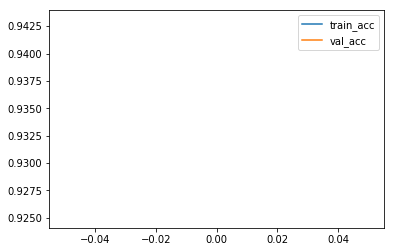

Ploting time: 0.27 s
Epoch: 0/7 Iteration: 10 Train loss: 0.043
10 Epochs training time: 0.59 s
Epoch: 0/7 Iteration: 20 Train loss: 0.045
10 Epochs training time: 0.592 s
Epoch: 0/7 Iteration: 30 Train loss: 0.037
10 Epochs training time: 0.594 s
Epoch: 0/7 Iteration: 40 Train loss: 0.035
10 Epochs training time: 0.594 s
Epoch: 0/7 Iteration: 50 Train loss: 0.035
10 Epochs training time: 0.596 s
Epoch: 0/7 Iteration: 60 Train loss: 0.047
10 Epochs training time: 0.596 s
Epoch: 0/7 Iteration: 70 Train loss: 0.041
10 Epochs training time: 0.6 s
Epoch: 0/7 Iteration: 80 Train loss: 0.039
10 Epochs training time: 0.604 s
Epoch: 0/7 Iteration: 90 Train loss: 0.041
10 Epochs training time: 0.6 s
Epoch: 0/7 Iteration: 100 Train loss: 0.041
10 Epochs training time: 0.599 s
Epoch: 0/7 Iteration: 110 Train loss: 0.061
10 Epochs training time: 0.6 s
Epoch: 0/7 Iteration: 120 Train loss: 0.037
10 Epochs training time: 0.604 s
Epoch: 0/7 Iteration: 130 Train loss: 0.051
10 Epochs training time: 0.

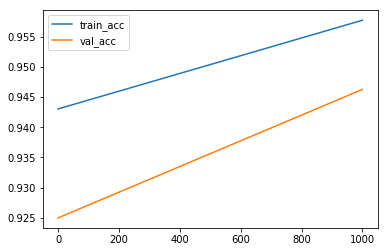

Ploting time: 0.179 s
Epoch: 0/7 Iteration: 1010 Train loss: 0.028
10 Epochs training time: 0.599 s
Epoch: 0/7 Iteration: 1020 Train loss: 0.059
10 Epochs training time: 0.599 s
Epoch: 0/7 Iteration: 1030 Train loss: 0.029
10 Epochs training time: 0.599 s
Epoch: 0/7 Iteration: 1040 Train loss: 0.043
10 Epochs training time: 0.604 s
Epoch: 0/7 Iteration: 1050 Train loss: 0.027
10 Epochs training time: 0.606 s
Epoch: 0/7 Iteration: 1060 Train loss: 0.042
10 Epochs training time: 0.599 s
Epoch: 0/7 Iteration: 1070 Train loss: 0.054
10 Epochs training time: 0.601 s
Epoch: 0/7 Iteration: 1080 Train loss: 0.034
10 Epochs training time: 0.602 s
Epoch: 0/7 Iteration: 1090 Train loss: 0.040
10 Epochs training time: 0.599 s
Epoch: 0/7 Iteration: 1100 Train loss: 0.037
10 Epochs training time: 0.6 s
Epoch: 0/7 Iteration: 1110 Train loss: 0.029
10 Epochs training time: 0.603 s
Epoch: 0/7 Iteration: 1120 Train loss: 0.029
10 Epochs training time: 0.599 s
Epoch: 0/7 Iteration: 1130 Train loss: 0.040

Epoch: 1/7 Iteration: 5320 Train loss: 0.019
10 Epochs training time: 0.606 s
Epoch: 1/7 Iteration: 5330 Train loss: 0.021
10 Epochs training time: 0.601 s
Epoch: 1/7 Iteration: 5340 Train loss: 0.010
10 Epochs training time: 0.6 s
Epoch: 1/7 Iteration: 5350 Train loss: 0.011
10 Epochs training time: 0.603 s
Epoch: 1/7 Iteration: 5360 Train loss: 0.029
10 Epochs training time: 0.6 s
Epoch: 1/7 Iteration: 5370 Train loss: 0.023
10 Epochs training time: 0.601 s
Epoch: 1/7 Iteration: 5380 Train loss: 0.016
10 Epochs training time: 0.602 s
Epoch: 1/7 Iteration: 5390 Train loss: 0.017
10 Epochs training time: 0.602 s
Epoch: 1/7 Iteration: 5400 Train loss: 0.025
10 Epochs training time: 0.602 s
Epoch: 1/7 Iteration: 5410 Train loss: 0.010
10 Epochs training time: 0.603 s
Epoch: 1/7 Iteration: 5420 Train loss: 0.042
10 Epochs training time: 0.603 s
Epoch: 1/7 Iteration: 5430 Train loss: 0.022
10 Epochs training time: 0.598 s
Epoch: 1/7 Iteration: 5440 Train loss: 0.017
10 Epochs training time

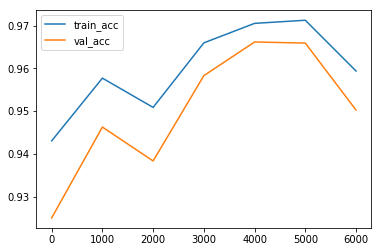

Ploting time: 0.212 s
Epoch: 1/7 Iteration: 6010 Train loss: 0.020
10 Epochs training time: 0.601 s
Epoch: 1/7 Iteration: 6020 Train loss: 0.031
10 Epochs training time: 0.601 s
Epoch: 1/7 Iteration: 6030 Train loss: 0.019
10 Epochs training time: 0.602 s
Epoch: 1/7 Iteration: 6040 Train loss: 0.020
10 Epochs training time: 0.603 s
Epoch: 1/7 Iteration: 6050 Train loss: 0.017
10 Epochs training time: 0.601 s
Epoch: 1/7 Iteration: 6060 Train loss: 0.020
10 Epochs training time: 0.604 s
Epoch: 1/7 Iteration: 6070 Train loss: 0.016
10 Epochs training time: 0.599 s
Epoch: 1/7 Iteration: 6080 Train loss: 0.013
10 Epochs training time: 0.6 s
Epoch: 1/7 Iteration: 6090 Train loss: 0.028
10 Epochs training time: 0.603 s
Epoch: 1/7 Iteration: 6100 Train loss: 0.040
10 Epochs training time: 0.603 s
Epoch: 1/7 Iteration: 6110 Train loss: 0.018
10 Epochs training time: 0.603 s
Epoch: 1/7 Iteration: 6120 Train loss: 0.017
10 Epochs training time: 0.603 s
Epoch: 1/7 Iteration: 6130 Train loss: 0.020

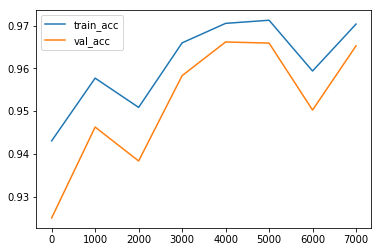

Ploting time: 0.208 s
Epoch: 1/7 Iteration: 7010 Train loss: 0.012
10 Epochs training time: 0.601 s
Epoch: 1/7 Iteration: 7020 Train loss: 0.036
10 Epochs training time: 0.603 s
Epoch: 1/7 Iteration: 7030 Train loss: 0.038
10 Epochs training time: 0.6 s
Epoch: 1/7 Iteration: 7040 Train loss: 0.035
10 Epochs training time: 0.603 s
Epoch: 1/7 Iteration: 7050 Train loss: 0.029
10 Epochs training time: 0.6 s
Epoch: 1/7 Iteration: 7060 Train loss: 0.026
10 Epochs training time: 0.599 s
Epoch: 1/7 Iteration: 7070 Train loss: 0.048
10 Epochs training time: 0.601 s
Epoch: 1/7 Iteration: 7080 Train loss: 0.042
10 Epochs training time: 0.608 s
Epoch: 1/7 Iteration: 7090 Train loss: 0.025
10 Epochs training time: 0.6 s
Epoch: 1/7 Iteration: 7100 Train loss: 0.041
10 Epochs training time: 0.603 s
Epoch: 1/7 Iteration: 7110 Train loss: 0.022
10 Epochs training time: 0.607 s
Epoch: 1/7 Iteration: 7120 Train loss: 0.044
10 Epochs training time: 0.602 s
Epoch: 1/7 Iteration: 7130 Train loss: 0.049
10 

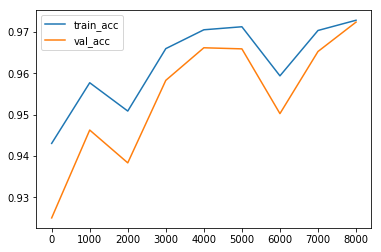

Ploting time: 0.232 s
Epoch: 2/7 Iteration: 8010 Train loss: 0.021
10 Epochs training time: 0.599 s
Epoch: 2/7 Iteration: 8020 Train loss: 0.017
10 Epochs training time: 0.601 s
Epoch: 2/7 Iteration: 8030 Train loss: 0.011
10 Epochs training time: 0.595 s
Epoch: 2/7 Iteration: 8040 Train loss: 0.010
10 Epochs training time: 0.599 s
Epoch: 2/7 Iteration: 8050 Train loss: 0.015
10 Epochs training time: 0.6 s
Epoch: 2/7 Iteration: 8060 Train loss: 0.019
10 Epochs training time: 0.601 s
Epoch: 2/7 Iteration: 8070 Train loss: 0.008
10 Epochs training time: 0.604 s
Epoch: 2/7 Iteration: 8080 Train loss: 0.021
10 Epochs training time: 0.604 s
Epoch: 2/7 Iteration: 8090 Train loss: 0.019
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 8100 Train loss: 0.017
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 8110 Train loss: 0.019
10 Epochs training time: 0.603 s
Epoch: 2/7 Iteration: 8120 Train loss: 0.011
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 8130 Train loss: 0.007

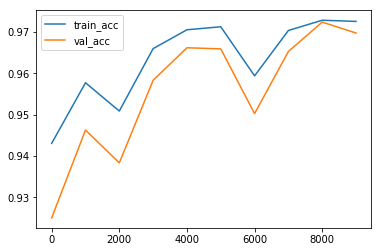

Ploting time: 0.172 s
Epoch: 2/7 Iteration: 9010 Train loss: 0.024
10 Epochs training time: 0.598 s
Epoch: 2/7 Iteration: 9020 Train loss: 0.014
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 9030 Train loss: 0.006
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 9040 Train loss: 0.015
10 Epochs training time: 0.601 s
Epoch: 2/7 Iteration: 9050 Train loss: 0.017
10 Epochs training time: 0.604 s
Epoch: 2/7 Iteration: 9060 Train loss: 0.021
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 9070 Train loss: 0.012
10 Epochs training time: 0.594 s
Epoch: 2/7 Iteration: 9080 Train loss: 0.028
10 Epochs training time: 0.6 s
Epoch: 2/7 Iteration: 9090 Train loss: 0.006
10 Epochs training time: 0.601 s
Epoch: 2/7 Iteration: 9100 Train loss: 0.019
10 Epochs training time: 0.603 s
Epoch: 2/7 Iteration: 9110 Train loss: 0.016
10 Epochs training time: 0.603 s
Epoch: 2/7 Iteration: 9120 Train loss: 0.019
10 Epochs training time: 0.601 s
Epoch: 2/7 Iteration: 9130 Train loss: 0.010

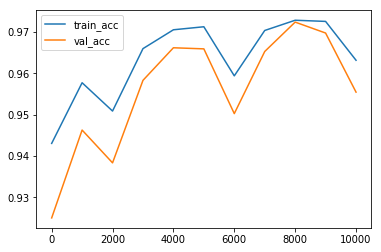

Ploting time: 0.174 s
Epoch: 2/7 Iteration: 10010 Train loss: 0.018
10 Epochs training time: 0.601 s
Epoch: 2/7 Iteration: 10020 Train loss: 0.014
10 Epochs training time: 0.601 s
Epoch: 2/7 Iteration: 10030 Train loss: 0.009
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 10040 Train loss: 0.011
10 Epochs training time: 0.6 s
Epoch: 2/7 Iteration: 10050 Train loss: 0.025
10 Epochs training time: 0.603 s
Epoch: 2/7 Iteration: 10060 Train loss: 0.030
10 Epochs training time: 0.601 s
Epoch: 2/7 Iteration: 10070 Train loss: 0.015
10 Epochs training time: 0.601 s
Epoch: 2/7 Iteration: 10080 Train loss: 0.018
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 10090 Train loss: 0.022
10 Epochs training time: 0.601 s
Epoch: 2/7 Iteration: 10100 Train loss: 0.024
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 10110 Train loss: 0.023
10 Epochs training time: 0.6 s
Epoch: 2/7 Iteration: 10120 Train loss: 0.018
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 10130 Train 

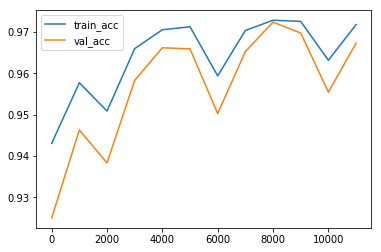

Ploting time: 0.198 s
Epoch: 2/7 Iteration: 11010 Train loss: 0.029
10 Epochs training time: 0.606 s
Epoch: 2/7 Iteration: 11020 Train loss: 0.022
10 Epochs training time: 0.6 s
Epoch: 2/7 Iteration: 11030 Train loss: 0.051
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 11040 Train loss: 0.050
10 Epochs training time: 0.604 s
Epoch: 2/7 Iteration: 11050 Train loss: 0.020
10 Epochs training time: 0.603 s
Epoch: 2/7 Iteration: 11060 Train loss: 0.028
10 Epochs training time: 0.604 s
Epoch: 2/7 Iteration: 11070 Train loss: 0.018
10 Epochs training time: 0.603 s
Epoch: 2/7 Iteration: 11080 Train loss: 0.040
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 11090 Train loss: 0.035
10 Epochs training time: 0.603 s
Epoch: 2/7 Iteration: 11100 Train loss: 0.019
10 Epochs training time: 0.6 s
Epoch: 2/7 Iteration: 11110 Train loss: 0.020
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 11120 Train loss: 0.029
10 Epochs training time: 0.602 s
Epoch: 2/7 Iteration: 11130 Train 

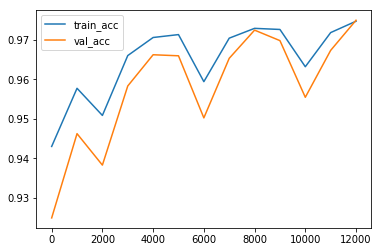

Ploting time: 0.227 s
Epoch: 3/7 Iteration: 12010 Train loss: 0.010
10 Epochs training time: 0.601 s
Epoch: 3/7 Iteration: 12020 Train loss: 0.016
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 12030 Train loss: 0.018
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 12040 Train loss: 0.012
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 12050 Train loss: 0.016
10 Epochs training time: 0.605 s
Epoch: 3/7 Iteration: 12060 Train loss: 0.016
10 Epochs training time: 0.601 s
Epoch: 3/7 Iteration: 12070 Train loss: 0.008
10 Epochs training time: 0.601 s
Epoch: 3/7 Iteration: 12080 Train loss: 0.009
10 Epochs training time: 0.603 s
Epoch: 3/7 Iteration: 12090 Train loss: 0.024
10 Epochs training time: 0.601 s
Epoch: 3/7 Iteration: 12100 Train loss: 0.010
10 Epochs training time: 0.603 s
Epoch: 3/7 Iteration: 12110 Train loss: 0.009
10 Epochs training time: 0.6 s
Epoch: 3/7 Iteration: 12120 Train loss: 0.005
10 Epochs training time: 0.601 s
Epoch: 3/7 Iteration: 12130 Trai

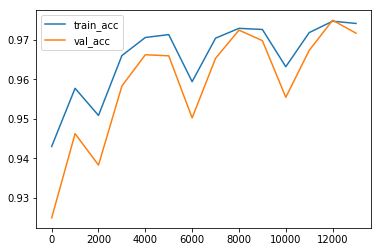

Ploting time: 0.211 s
Epoch: 3/7 Iteration: 13010 Train loss: 0.018
10 Epochs training time: 0.6 s
Epoch: 3/7 Iteration: 13020 Train loss: 0.013
10 Epochs training time: 0.604 s
Epoch: 3/7 Iteration: 13030 Train loss: 0.021
10 Epochs training time: 0.601 s
Epoch: 3/7 Iteration: 13040 Train loss: 0.015
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 13050 Train loss: 0.008
10 Epochs training time: 0.604 s
Epoch: 3/7 Iteration: 13060 Train loss: 0.006
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 13070 Train loss: 0.014
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 13080 Train loss: 0.016
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 13090 Train loss: 0.023
10 Epochs training time: 0.6 s
Epoch: 3/7 Iteration: 13100 Train loss: 0.015
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 13110 Train loss: 0.015
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 13120 Train loss: 0.003
10 Epochs training time: 0.603 s
Epoch: 3/7 Iteration: 13130 Train 

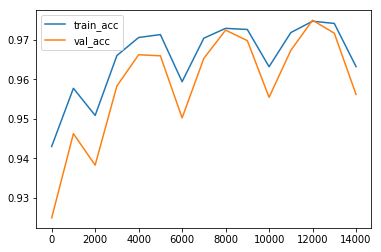

Ploting time: 0.217 s
Epoch: 3/7 Iteration: 14010 Train loss: 0.010
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 14020 Train loss: 0.016
10 Epochs training time: 0.604 s
Epoch: 3/7 Iteration: 14030 Train loss: 0.015
10 Epochs training time: 0.604 s
Epoch: 3/7 Iteration: 14040 Train loss: 0.014
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 14050 Train loss: 0.022
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 14060 Train loss: 0.018
10 Epochs training time: 0.608 s
Epoch: 3/7 Iteration: 14070 Train loss: 0.019
10 Epochs training time: 0.604 s
Epoch: 3/7 Iteration: 14080 Train loss: 0.016
10 Epochs training time: 0.605 s
Epoch: 3/7 Iteration: 14090 Train loss: 0.019
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 14100 Train loss: 0.025
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 14110 Train loss: 0.009
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 14120 Train loss: 0.014
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 14130 Tr

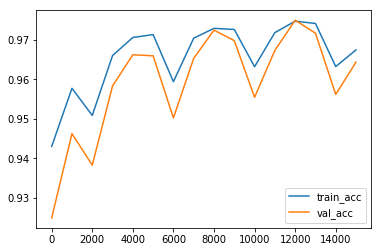

Ploting time: 0.173 s
Epoch: 3/7 Iteration: 15010 Train loss: 0.039
10 Epochs training time: 0.604 s
Epoch: 3/7 Iteration: 15020 Train loss: 0.022
10 Epochs training time: 0.601 s
Epoch: 3/7 Iteration: 15030 Train loss: 0.022
10 Epochs training time: 0.603 s
Epoch: 3/7 Iteration: 15040 Train loss: 0.023
10 Epochs training time: 0.604 s
Epoch: 3/7 Iteration: 15050 Train loss: 0.014
10 Epochs training time: 0.603 s
Epoch: 3/7 Iteration: 15060 Train loss: 0.021
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 15070 Train loss: 0.030
10 Epochs training time: 0.6 s
Epoch: 3/7 Iteration: 15080 Train loss: 0.030
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 15090 Train loss: 0.049
10 Epochs training time: 0.604 s
Epoch: 3/7 Iteration: 15100 Train loss: 0.038
10 Epochs training time: 0.604 s
Epoch: 3/7 Iteration: 15110 Train loss: 0.030
10 Epochs training time: 0.605 s
Epoch: 3/7 Iteration: 15120 Train loss: 0.038
10 Epochs training time: 0.602 s
Epoch: 3/7 Iteration: 15130 Trai

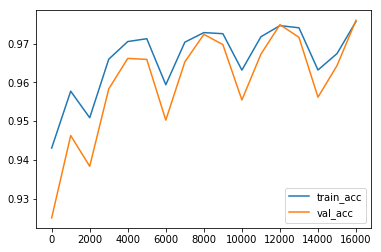

Ploting time: 0.242 s
Epoch: 4/7 Iteration: 16010 Train loss: 0.009
10 Epochs training time: 0.604 s
Epoch: 4/7 Iteration: 16020 Train loss: 0.013
10 Epochs training time: 0.603 s
Epoch: 4/7 Iteration: 16030 Train loss: 0.011
10 Epochs training time: 0.603 s
Epoch: 4/7 Iteration: 16040 Train loss: 0.011
10 Epochs training time: 0.605 s
Epoch: 4/7 Iteration: 16050 Train loss: 0.007
10 Epochs training time: 0.603 s
Epoch: 4/7 Iteration: 16060 Train loss: 0.019
10 Epochs training time: 0.604 s
Epoch: 4/7 Iteration: 16070 Train loss: 0.007
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 16080 Train loss: 0.011
10 Epochs training time: 0.601 s
Epoch: 4/7 Iteration: 16090 Train loss: 0.015
10 Epochs training time: 0.603 s
Epoch: 4/7 Iteration: 16100 Train loss: 0.017
10 Epochs training time: 0.601 s
Epoch: 4/7 Iteration: 16110 Train loss: 0.018
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 16120 Train loss: 0.015
10 Epochs training time: 0.603 s
Epoch: 4/7 Iteration: 16130 Tr

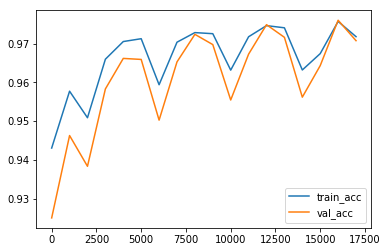

Ploting time: 0.223 s
Epoch: 4/7 Iteration: 17010 Train loss: 0.013
10 Epochs training time: 0.606 s
Epoch: 4/7 Iteration: 17020 Train loss: 0.017
10 Epochs training time: 0.604 s
Epoch: 4/7 Iteration: 17030 Train loss: 0.020
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 17040 Train loss: 0.014
10 Epochs training time: 0.604 s
Epoch: 4/7 Iteration: 17050 Train loss: 0.011
10 Epochs training time: 0.601 s
Epoch: 4/7 Iteration: 17060 Train loss: 0.008
10 Epochs training time: 0.603 s
Epoch: 4/7 Iteration: 17070 Train loss: 0.012
10 Epochs training time: 0.604 s
Epoch: 4/7 Iteration: 17080 Train loss: 0.011
10 Epochs training time: 0.606 s
Epoch: 4/7 Iteration: 17090 Train loss: 0.007
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 17100 Train loss: 0.006
10 Epochs training time: 0.603 s
Epoch: 4/7 Iteration: 17110 Train loss: 0.010
10 Epochs training time: 0.603 s
Epoch: 4/7 Iteration: 17120 Train loss: 0.011
10 Epochs training time: 0.603 s
Epoch: 4/7 Iteration: 17130 Tr

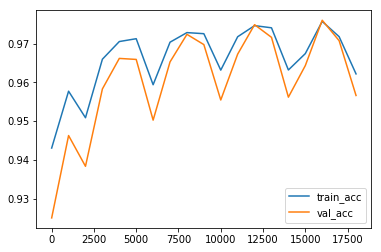

Ploting time: 0.175 s
Epoch: 4/7 Iteration: 18010 Train loss: 0.020
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 18020 Train loss: 0.029
10 Epochs training time: 0.601 s
Epoch: 4/7 Iteration: 18030 Train loss: 0.021
10 Epochs training time: 0.603 s
Epoch: 4/7 Iteration: 18040 Train loss: 0.007
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 18050 Train loss: 0.013
10 Epochs training time: 0.604 s
Epoch: 4/7 Iteration: 18060 Train loss: 0.020
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 18070 Train loss: 0.005
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 18080 Train loss: 0.019
10 Epochs training time: 0.601 s
Epoch: 4/7 Iteration: 18090 Train loss: 0.005
10 Epochs training time: 0.603 s
Epoch: 4/7 Iteration: 18100 Train loss: 0.009
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 18110 Train loss: 0.019
10 Epochs training time: 0.601 s
Epoch: 4/7 Iteration: 18120 Train loss: 0.005
10 Epochs training time: 0.604 s
Epoch: 4/7 Iteration: 18130 Tr

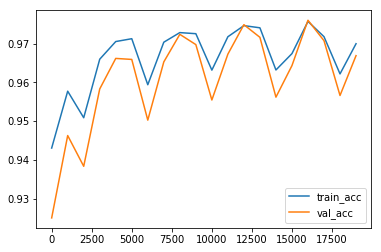

Ploting time: 0.182 s
Epoch: 4/7 Iteration: 19010 Train loss: 0.028
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 19020 Train loss: 0.016
10 Epochs training time: 0.604 s
Epoch: 4/7 Iteration: 19030 Train loss: 0.027
10 Epochs training time: 0.606 s
Epoch: 4/7 Iteration: 19040 Train loss: 0.022
10 Epochs training time: 0.604 s
Epoch: 4/7 Iteration: 19050 Train loss: 0.031
10 Epochs training time: 0.607 s
Epoch: 4/7 Iteration: 19060 Train loss: 0.014
10 Epochs training time: 0.603 s
Epoch: 4/7 Iteration: 19070 Train loss: 0.038
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 19080 Train loss: 0.025
10 Epochs training time: 0.603 s
Epoch: 4/7 Iteration: 19090 Train loss: 0.008
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 19100 Train loss: 0.016
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 19110 Train loss: 0.025
10 Epochs training time: 0.601 s
Epoch: 4/7 Iteration: 19120 Train loss: 0.024
10 Epochs training time: 0.602 s
Epoch: 4/7 Iteration: 19130 Tr

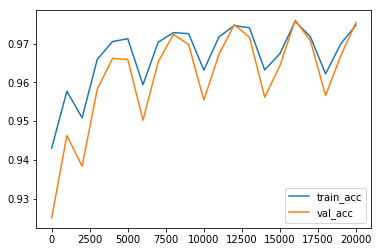

Ploting time: 0.256 s
Epoch: 5/7 Iteration: 20010 Train loss: 0.009
10 Epochs training time: 0.602 s
Epoch: 5/7 Iteration: 20020 Train loss: 0.003
10 Epochs training time: 0.608 s
Epoch: 5/7 Iteration: 20030 Train loss: 0.008
10 Epochs training time: 0.608 s
Epoch: 5/7 Iteration: 20040 Train loss: 0.008
10 Epochs training time: 0.599 s
Epoch: 5/7 Iteration: 20050 Train loss: 0.009
10 Epochs training time: 0.604 s
Epoch: 5/7 Iteration: 20060 Train loss: 0.004
10 Epochs training time: 0.603 s
Epoch: 5/7 Iteration: 20070 Train loss: 0.020
10 Epochs training time: 0.604 s
Epoch: 5/7 Iteration: 20080 Train loss: 0.007
10 Epochs training time: 0.602 s
Epoch: 5/7 Iteration: 20090 Train loss: 0.005
10 Epochs training time: 0.604 s
Epoch: 5/7 Iteration: 20100 Train loss: 0.006
10 Epochs training time: 0.606 s
Epoch: 5/7 Iteration: 20110 Train loss: 0.008
10 Epochs training time: 0.602 s
Epoch: 5/7 Iteration: 20120 Train loss: 0.012
10 Epochs training time: 0.6 s
Epoch: 5/7 Iteration: 20130 Trai

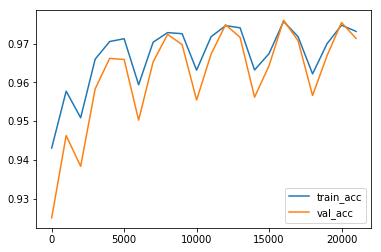

Ploting time: 0.201 s
Epoch: 5/7 Iteration: 21010 Train loss: 0.008
10 Epochs training time: 0.607 s
Epoch: 5/7 Iteration: 21020 Train loss: 0.013
10 Epochs training time: 0.603 s
Epoch: 5/7 Iteration: 21030 Train loss: 0.012
10 Epochs training time: 0.604 s
Epoch: 5/7 Iteration: 21040 Train loss: 0.011
10 Epochs training time: 0.605 s
Epoch: 5/7 Iteration: 21050 Train loss: 0.029
10 Epochs training time: 0.615 s
Epoch: 5/7 Iteration: 21060 Train loss: 0.014
10 Epochs training time: 0.604 s
Epoch: 5/7 Iteration: 21070 Train loss: 0.010
10 Epochs training time: 0.603 s
Epoch: 5/7 Iteration: 21080 Train loss: 0.008
10 Epochs training time: 0.602 s
Epoch: 5/7 Iteration: 21090 Train loss: 0.006
10 Epochs training time: 0.599 s
Epoch: 5/7 Iteration: 21100 Train loss: 0.009
10 Epochs training time: 0.602 s
Epoch: 5/7 Iteration: 21110 Train loss: 0.004
10 Epochs training time: 0.599 s
Epoch: 5/7 Iteration: 21120 Train loss: 0.004
10 Epochs training time: 0.604 s
Epoch: 5/7 Iteration: 21130 Tr

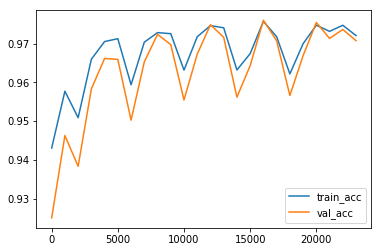

Ploting time: 0.2 s
Epoch: 5/7 Iteration: 23010 Train loss: 0.021
10 Epochs training time: 0.603 s
Epoch: 5/7 Iteration: 23020 Train loss: 0.019
10 Epochs training time: 0.603 s
Epoch: 5/7 Iteration: 23030 Train loss: 0.033
10 Epochs training time: 0.605 s
Epoch: 5/7 Iteration: 23040 Train loss: 0.016
10 Epochs training time: 0.606 s
Epoch: 5/7 Iteration: 23050 Train loss: 0.014
10 Epochs training time: 0.603 s
Epoch: 5/7 Iteration: 23060 Train loss: 0.016
10 Epochs training time: 0.602 s
Epoch: 5/7 Iteration: 23070 Train loss: 0.022
10 Epochs training time: 0.606 s
Epoch: 5/7 Iteration: 23080 Train loss: 0.019
10 Epochs training time: 0.607 s
Epoch: 5/7 Iteration: 23090 Train loss: 0.009
10 Epochs training time: 0.611 s
Epoch: 5/7 Iteration: 23100 Train loss: 0.016
10 Epochs training time: 0.605 s
Epoch: 5/7 Iteration: 23110 Train loss: 0.017
10 Epochs training time: 0.605 s
Epoch: 5/7 Iteration: 23120 Train loss: 0.012
10 Epochs training time: 0.603 s
Epoch: 5/7 Iteration: 23130 Trai

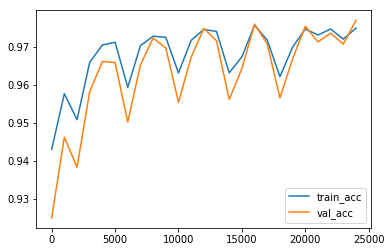

Ploting time: 0.287 s
Epoch: 6/7 Iteration: 24010 Train loss: 0.012
10 Epochs training time: 0.601 s
Epoch: 6/7 Iteration: 24020 Train loss: 0.009
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 24030 Train loss: 0.010
10 Epochs training time: 0.603 s
Epoch: 6/7 Iteration: 24040 Train loss: 0.013
10 Epochs training time: 0.604 s
Epoch: 6/7 Iteration: 24050 Train loss: 0.008
10 Epochs training time: 0.605 s
Epoch: 6/7 Iteration: 24060 Train loss: 0.011
10 Epochs training time: 0.601 s
Epoch: 6/7 Iteration: 24070 Train loss: 0.011
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 24080 Train loss: 0.010
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 24090 Train loss: 0.007
10 Epochs training time: 0.604 s
Epoch: 6/7 Iteration: 24100 Train loss: 0.010
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 24110 Train loss: 0.009
10 Epochs training time: 0.603 s
Epoch: 6/7 Iteration: 24120 Train loss: 0.007
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 24130 Tr

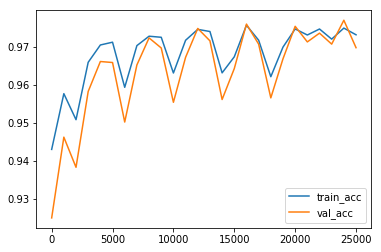

Ploting time: 0.179 s
Epoch: 6/7 Iteration: 25010 Train loss: 0.005
10 Epochs training time: 0.613 s
Epoch: 6/7 Iteration: 25020 Train loss: 0.004
10 Epochs training time: 0.604 s
Epoch: 6/7 Iteration: 25030 Train loss: 0.007
10 Epochs training time: 0.604 s
Epoch: 6/7 Iteration: 25040 Train loss: 0.005
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 25050 Train loss: 0.010
10 Epochs training time: 0.601 s
Epoch: 6/7 Iteration: 25060 Train loss: 0.007
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 25070 Train loss: 0.013
10 Epochs training time: 0.603 s
Epoch: 6/7 Iteration: 25080 Train loss: 0.008
10 Epochs training time: 0.604 s
Epoch: 6/7 Iteration: 25090 Train loss: 0.011
10 Epochs training time: 0.604 s
Epoch: 6/7 Iteration: 25100 Train loss: 0.007
10 Epochs training time: 0.601 s
Epoch: 6/7 Iteration: 25110 Train loss: 0.013
10 Epochs training time: 0.603 s
Epoch: 6/7 Iteration: 25120 Train loss: 0.009
10 Epochs training time: 0.601 s
Epoch: 6/7 Iteration: 25130 Tr

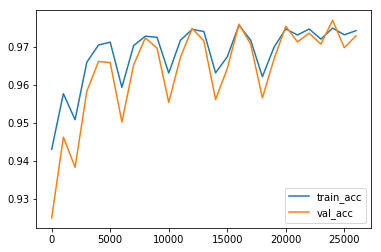

Ploting time: 0.191 s
Epoch: 6/7 Iteration: 26010 Train loss: 0.010
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 26020 Train loss: 0.005
10 Epochs training time: 0.603 s
Epoch: 6/7 Iteration: 26030 Train loss: 0.008
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 26040 Train loss: 0.010
10 Epochs training time: 0.603 s
Epoch: 6/7 Iteration: 26050 Train loss: 0.008
10 Epochs training time: 0.604 s
Epoch: 6/7 Iteration: 26060 Train loss: 0.008
10 Epochs training time: 0.6 s
Epoch: 6/7 Iteration: 26070 Train loss: 0.012
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 26080 Train loss: 0.016
10 Epochs training time: 0.603 s
Epoch: 6/7 Iteration: 26090 Train loss: 0.007
10 Epochs training time: 0.603 s
Epoch: 6/7 Iteration: 26100 Train loss: 0.006
10 Epochs training time: 0.604 s
Epoch: 6/7 Iteration: 26110 Train loss: 0.008
10 Epochs training time: 0.603 s
Epoch: 6/7 Iteration: 26120 Train loss: 0.007
10 Epochs training time: 0.601 s
Epoch: 6/7 Iteration: 26130 Trai

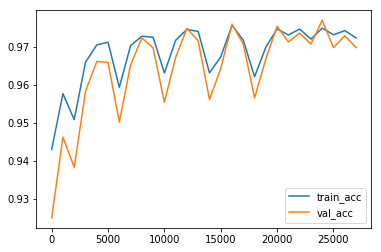

Ploting time: 0.216 s
Epoch: 6/7 Iteration: 27010 Train loss: 0.016
10 Epochs training time: 0.601 s
Epoch: 6/7 Iteration: 27020 Train loss: 0.019
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 27030 Train loss: 0.013
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 27040 Train loss: 0.017
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 27050 Train loss: 0.025
10 Epochs training time: 0.604 s
Epoch: 6/7 Iteration: 27060 Train loss: 0.012
10 Epochs training time: 0.603 s
Epoch: 6/7 Iteration: 27070 Train loss: 0.014
10 Epochs training time: 0.603 s
Epoch: 6/7 Iteration: 27080 Train loss: 0.006
10 Epochs training time: 0.604 s
Epoch: 6/7 Iteration: 27090 Train loss: 0.013
10 Epochs training time: 0.602 s
Epoch: 6/7 Iteration: 27100 Train loss: 0.014
10 Epochs training time: 0.606 s
Epoch: 6/7 Iteration: 27110 Train loss: 0.010
10 Epochs training time: 0.605 s
Epoch: 6/7 Iteration: 27120 Train loss: 0.011
10 Epochs training time: 0.603 s
Epoch: 6/7 Iteration: 27130 Tr

In [ ]:
from time import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline


print("START")
t0 = time()



with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 0
    
    with open(file_output, "r+") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(cathegory)
    
        epochs_stat = []
        iteration_stat = []
        train_accs_stat = []
        val_accs_stat = []
        best_val_accs = 0
        
        
        for e in range(num_epochs):
            state = sess.run(initial_state)
            

            for ii, (x, y, wort) in enumerate(get_batches(train_x, train_y, train_woerter, batch_size), 1):
                
                #Training the network (after every batch the weights gets updated)
                t1 = time()
                
                feed = {inputs_: x,
                        labels_: y[:,None],
                        keep_prob: 0.85,
                        initial_state: state}  # normally 0.5 (0.6 - 0.7 for best results so far)
                loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)

                #Print out status
                if iteration%10==0:
                    print("Epoch: {}/{}".format(e, num_epochs),
                          "Iteration: {}".format(iteration),
                          "Train loss: {:.3f}".format(loss))
                    print("10 Epochs training time:", round(time()-t1, 3), "s")
                

                if iteration%1000==0:
                    
                    t2 = time()
                    
                    train_acc = []
                    val_acc = []
                    
                    #Training set accuracy
                    train_acc_state = sess.run(cell.zero_state(batch_size, tf.float32))
                    for x, y, wort in get_batches(train_acc_x, train_acc_y, woerter, batch_size):
                        feed = {inputs_: x,
                                labels_: y[:,None],
                                keep_prob: 1,
                                initial_state: state}
                        batch_acc, train_acc_state = sess.run([accuracy, final_state], feed_dict=feed)
                        train_acc.append(batch_acc)
                    print("Train acc: {:.3f}".format(np.mean(train_acc)))
                    
                    
                    #Validation set accuracy
                    val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                    for x, y, wort in get_batches(val_x, val_y, val_woerter, batch_size):
                        feed = {inputs_: x,
                                labels_: y[:,None],
                                keep_prob: 1,
                                initial_state: val_state}
                        batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                        val_acc.append(batch_acc)
                    print("Val acc: {:.3f}".format(np.mean(val_acc)))
                    
                    val_accs = np.mean(val_acc)
                    train_accs = np.mean(train_acc)
                    
                    to_write = [e] + [iteration] + [val_accs] + [train_accs]
                    writer.writerow(to_write)
                    
                    epochs_stat.append(e)
                    iteration_stat.append(iteration)
                    train_accs_stat.append(train_accs)
                    val_accs_stat.append(val_accs)
                    
                    print("1 Validation time:", round(time()-t2, 3), "s")
                    
                    
                    #Safe checkpoint if it is better than prior results
                    t4 = time()
                    
                    if best_val_accs < val_accs:
                        best_val_accs = val_accs
                        saver.save(sess, "checkpoints/best.ckpt")
                        print("New best saving time:", round(time()-t4, 3), "s")
                        
                        
                if iteration%1000==0:
                    
                    #Plot a graph with the validation and training accuracies
                    t3 = time()
                    
                    plt.figure()
                    plt.plot(iteration_stat, train_accs_stat, label="train_acc")
                    plt.plot(iteration_stat, val_accs_stat, label="val_acc")
                    plt.legend()
                    _ = plt.ylim()
                    plt.show()
                    plt.pause(0.0001) #Just short necessary stop to show the plot
                    
                    print("Ploting time:", round(time()-t3, 3), "s")
                       
                
                iteration +=1
                
                        
    #saver.save(sess, "checkpoints/last.ckpt")
    print("Total time:", round(time()-t0, 3), "s")
    
    print("FINISH !!!!")

In [31]:
print("Kernel still alive :)")

Kernel still alive :)


# Valididation accuracy graph

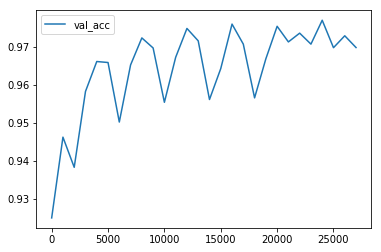

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(iteration_stat, val_accs_stat, label="val_acc")
plt.legend()
_ = plt.ylim()
plt.show()


# Testing


In [34]:
test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y, wort) in enumerate(get_batches(test_x, test_y, test_woerter, batch_size), 1):
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

Test accuracy: 0.975


### Show samples of testing batch
Gives really good insights by showing:
prediction, label, text

In [35]:
predictions_list = []
batch_size = 512
counter_max = 3

with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    val_state = sess.run(cell.zero_state(batch_size, tf.float32))
    
    counter = 0
    
    for ii, (x, y, wort) in enumerate(get_batches(test_x, test_y, test_woerter, batch_size), 1):
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: val_state}
        prediction = sess.run(predictions, feed_dict=feed)
    
        for i in range(0,len(prediction)):
            predictions_list.append([round(float(prediction[i]),4), y[i], wort[i]])
        
        ###    
        if counter == counter_max:
            break
        counter += 1
        ###
        
        
        
prediction_list = list(predictions_list)
for iii in range(0, len(prediction_list)):
    print(prediction_list[iii])
  
    

[0.0018, 0, 'gleich']
[0.0028, 0, 'morg']
[0.0011, 0, 'fruh']
[0.0023, 0, 'wollt']
[0.0037, 0, 'sich']
[0.0008, 0, 'all']
[0.0005, 0, 'bei']
[0.0008, 0, 'hild']
[0.0018, 0, 'wohnung']
[0.0006, 0, 'treff']
[0.0004, 0, '.']
[0.0059, 0, 'nach']
[0.0009, 0, 'dem']
[0.0011, 0, 'abendess']
[0.0021, 0, 'fuhr']
[0.0046, 0, 'philipps']
[0.0058, 0, 'vat']
[0.0093, 0, 'hild']
[0.0634, 0, 'mit']
[0.0308, 0, 'einig']
[0.0122, 0, 'karton']
[0.0063, 0, 'zuruck']
[0.0544, 0, 'zu']
[0.0069, 0, 'ihr']
[0.0013, 0, 'wohnung']
[0.0009, 0, '.']
[0.0031, 0, 'sie']
[0.0037, 0, 'sollt']
[0.0035, 0, 'schon']
[0.0029, 0, 'einmal']
[0.0042, 0, 'anfang']
[0.9145, 1, 'ihr']
[0.0025, 0, 'sach']
[0.0048, 0, 'einzupack']
[0.9917, 1, 'dann']
[0.0009, 0, 'wurd']
[0.0027, 0, 'es']
[0.0018, 0, 'am']
[0.0008, 0, 'nach']
[0.0008, 0, 'tag']
[0.0005, 0, 'schnell']
[0.0004, 0, 'geh']
[0.0005, 0, '.']
[0.0012, 0, 'sie']
[0.0027, 0, 'bedankt']
[0.0062, 0, 'sich']
[0.0008, 0, 'imm']
[0.0024, 0, 'wied']
[0.0162, 0, 'bei']
[0.0065,

[0.0049, 0, 'dem']
[0.0021, 0, 'lad']
[0.0031, 0, 'bewerb']
[0.0068, 0, 'wurd']
[0.9567, 1, 'gleich']
[0.0117, 0, 'am']
[0.0271, 0, 'nach']
[0.0196, 0, 'morg']
[0.2427, 0, 'wollt']
[0.0031, 0, 'sie']
[0.0013, 0, 'sich']
[0.0006, 0, 'dort']
[0.0007, 0, 'vorstell']
[0.0007, 0, '.']
[0.0071, 0, 'wenn']
[0.0056, 0, 'das']
[0.0116, 0, 'klappt']
[0.9335, 1, 'wurd']
[0.0155, 0, 'sie']
[0.0169, 0, 'vielleicht']
[0.0063, 0, 'herausfind']
[0.9896, 1, 'was']
[0.001, 0, 'willi']
[0.0043, 0, 'sonst']
[0.0054, 0, 'noch']
[0.0051, 0, 'so']
[0.0032, 0, 'am']
[0.003, 0, 'lauf']
[0.0038, 0, 'hatt']
[0.9826, 1, 'von']
[0.0013, 0, 'dem']
[0.0022, 0, 'sie']
[0.0008, 0, 'all']
[0.0007, 0, 'bish']
[0.0011, 0, 'noch']
[0.0009, 0, 'nicht']
[0.0005, 0, 'wusst']
[0.0008, 0, '.']
[0.0009, 0, 'die']
[0.0015, 0, 'vier']
[0.0043, 0, 'ging']
[0.0041, 0, 'noch']
[0.0036, 0, 'ins']
[0.0097, 0, 'wass']
[0.0121, 0, 'und']
[0.003, 0, 'den']
[0.0026, 0, 'rest']
[0.0047, 0, 'des']
[0.0013, 0, 'abend']
[0.0005, 0, 'sass']
[0

# USE TRAINED NEURONAL NET ON NEW TEXT

### Preprocess the input text

In [54]:
import time
import numpy as np
import tensorflow as tf
import re
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def preprocess(text_name, vocabs_to_int=vocabs_to_int, int_to_vocabs=int_to_vocabs):
    
    ## Open text file
    with open(text_name, "r", encoding="utf-8") as text:
        text = text.read()
    
    ## Filtering out page numbers
    text = re.sub(r'\n[0-9]+ \n', '', text)
    text = re.sub(r'\n\n[a-zA-Z] \n\n', '', text)
    
    ## Tokenizing
    woerter = word_tokenize(text)
    
    ## Stemming
    sno = nltk.stem.SnowballStemmer('german')
    woerter_stem = [sno.stem(wort) for wort in woerter]
    
    ## POS
    root = '/output/'
    #root = '/Users/Till/Dropbox/Deep Learning Udacity/deep-learning/KommasetzungAusweichordner'
    fileid = 'tiger_release_aug07.corrected.16012013.conll09'
    columntypes = ['ignore', 'words', 'ignore', 'ignore', 'pos']
    
    #corp = nltk.corpus.ConllCorpusReader(root, fileid, columntypes, encoding='utf8')
    #tagged_sents = corp.tagged_sents()
    #tagger = ClassifierBasedGermanTagger(train=corp.tagged_sents())
    w_classes = tagger.tag(woerter)
    
    ## Mark punctuation with a "c"
    woerter_classes = []
    for word in w_classes:
        if "$" in str(word[1]):
            word_class = word[0] + "c"
        else:
            word_class = word[1]
        woerter_classes.append(word_class)
        
    ## Sample doesn't have any commas so they also don't have to be removed
    
    ## Generate features with the use of look up table (if not in lookup table -> None)   
    woerter_ints = [vocabs_to_int[wort] if wort in vocabs_to_int else vocabs_to_int["None"] for wort in woerter_stem]
    woerter_classes_ints = [vocabs_to_int[wort] if wort in vocabs_to_int else vocabs_to_int["None"] for wort in woerter_classes]
    
    
    ## Generate features
    features = []
    feature_woerter = [get_batch(woerter_ints, idx, window_size=10) for idx in range(0,len(woerter_ints))]
    feature_classes =  [get_batch(woerter_classes_ints, idx, window_size=10) for idx in range(0,len(woerter_ints))]
    features = list(zip(feature_woerter, feature_classes))
    features = np.asarray(features).reshape(len(woerter_ints), -1)
    
    return features, woerter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Predicting location of commas

In [74]:
predictions_list = []
batch_size = 512

with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint("checkpoints"))
    val_state = sess.run(cell.zero_state(batch_size, tf.float32))
    x, woerter = preprocess("test.txt")
    
    for ii, (x, y, wort) in enumerate(get_batches(x, test_y, woerter, batch_size), 1):
        
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: val_state}
        prediction = sess.run(predictions, feed_dict=feed)
    
        for i in range(0,len(prediction)):
            predictions_list.append([round(float(prediction[i]),4), wort[i]])
        
        
predictions_list = list(predictions_list)


for iii in predictions_list:
    print(iii)

[0.0067, 'Haupt-']
[0.0027, 'und']
[0.0016, 'Nebensätze']
[0.0053, ':']
[0.0114, 'Weil']
[0.0062, 'mir']
[0.0035, 'langweilig']
[0.0195, 'war']
[0.9142, 'rief']
[0.0019, 'ich']
[0.0031, 'meinen']
[0.0018, 'Freund']
[0.001, 'an']
[0.0009, '.']
[0.003, 'Er']
[0.0029, 'schlug']
[0.0042, 'vor']
[0.992, 'dass']
[0.0016, 'ich']
[0.0035, 'zu']
[0.005, 'ihm']
[0.0034, 'kommen']
[0.0018, 'solle']
[0.0008, '.']
[0.0034, 'Ich']
[0.011, 'fragte']
[0.0056, 'meine']
[0.0025, 'Mutter']
[0.9935, 'ob']
[0.0008, 'ich']
[0.0027, 'gehen']
[0.0035, 'könne']
[0.0026, '.']
[0.001, 'Sie']
[0.0049, 'war']
[0.002, 'einverstanden']
[0.0016, 'und']
[0.0022, 'wollte']
[0.0061, 'nur']
[0.9853, 'dass']
[0.0011, 'ich']
[0.0021, 'um']
[0.0025, '6']
[0.0017, 'wieder']
[0.0012, 'nach']
[0.0006, 'Hause']
[0.0004, 'komme']
[0.0005, '.']
[0.0026, 'Nachdem']
[0.0014, 'ich']
[0.0021, 'an']
[0.0032, 'Toms']
[0.0032, 'Wohnungstür']
[0.002, 'geklingelt']
[0.003, 'hatte']
[0.9937, 'ging']
[0.001, 'sie']
[0.009, 'auf']
[0.1159, '

[0.0045, 'Bahn']
[0.0055, 'zu']
[0.004, 'fahren']
[0.9761, 'als']
[0.0047, 'stundenlang']
[0.0056, 'auf']
[0.0152, 'der']
[0.0015, 'Autobahn']
[0.0032, 'im']
[0.0043, 'Stau']
[0.0015, 'zu']
[0.0007, 'stecken']
[0.0006, '.']
[0.0034, 'Sie']
[0.0028, 'brauchen']
[0.0097, 'nichts']
[0.0309, 'anderes']
[0.0091, 'zu']
[0.0053, 'tun']
[0.7652, 'als']
[0.0008, 'den']
[0.0006, 'Apparat']
[0.0004, 'an']
[0.0012, 'eine']
[0.0009, 'Steckdose']
[0.0011, 'anzuschliessen']
[0.0048, 'und']
[0.001, 'einzuschalten']
[0.0005, '.']
[0.0016, 'Manche']
[0.0028, 'geben']
[0.0032, 'mehr']
[0.003, 'Geld']
[0.0036, 'aus']
[0.9847, 'als']
[0.0013, 'sie']
[0.0041, 'verdienen']
[0.006, '.']
[0.0106, 'Etwas']
[0.0413, 'Schöneres']
[0.9003, 'als']
[0.0107, 'bei']
[0.0035, 'dir']
[0.0045, 'zu']
[0.006, 'sein']
[0.9306, 'gibt']
[0.0029, 'es']
[0.0016, 'nicht']
[0.0019, '!']
[0.0041, 'Ihr']
[0.0042, 'grösster']
[0.0061, 'Wunsch']
[0.0141, 'war']
[0.0396, 'es']
[0.0811, 'eine']
[0.0187, 'Familie']
[0.0031, 'zu']
[0.001

## Putting it back in a textual format
Commas with a prediction higher than the upper_gate will be added with ",". Predictions just higher that the lower_gate will be added with "(,)"

In [56]:
import string

def retext(upper_gate, lower_gate, pred = predictions_list):
    text = [t[1] for t in pred]
    
    for i in range(1, len(pred)):
        if pred[i][0] >= upper_gate:
            text[i-1] = str(text[i-1]) + ","
        elif  upper_gate > pred[i][0] >= lower_gate:
            text[i-1] = str(text[i-1]) + "(,)"
    
        if str(pred[i][1]) in str(string.punctuation):
            text[i-1] = text[i-1] + text[i]
            text[i] = "XXX"
            
    text = [te for te in text if "XXX" not in te]
    ready_text = " ".join(text)
    return ready_text

In [57]:
#prediction_list = [[pred, wort] for pred, lab, wort in prediction_list]
retext(0.9, 0.8)

'Haupt- und Nebensätze: Weil mir langweilig war, rief ich meinen Freund an. Er schlug vor, dass ich zu ihm kommen solle. Ich fragte meine Mutter, ob ich gehen könne. Sie war einverstanden und wollte nur, dass ich um 6 wieder nach Hause komme. Nachdem ich an Toms Wohnungstür geklingelt hatte, ging sie auf und sein Hund sprang auf mich zu. Wenn er mich so stürmisch begrüßt ist mir immer etwas mulmig zumute. Bevor er mich fressen konnte, rief Tom ihn zurück. Nachdem Struppi sich beruhigt hatte, ließ er sich von mir hinter den Schlappohren kraulen. Dann fragte mich Tom, ob ich das neueste Kunststück sehen wollte, das sie einstudiert hatten. Bevor ich etwas sagen konnte, brachte Struppi in seinem Maul 3 kleine Bälle und legte sie vor Toms Füßen ab. Der nahm sie und begann damit zu jonglieren. Als er zwischendurch immer einen Ball auf sein angezogenes Knie fallen ließ und ihn von dort wieder noch oben kicken wollte schnappte sich Struppi diesen Ball. Ich applaudierte. Nachdem er dieses Kunst

### This is just a preversion!!! The time wasn't sufficient to increase performance to a generell knowledge. There are still tones of possible improvments and ideas. To get the best possible performance it is still really important to train it on the right sort of text and tune the decision bounderies (from which prediction possiblity level on it will really set the comma) by hand . For more formal texts, later on a different data set was used. Because of time and money constraints the training resources were really limited. Also the excess to good and clean data sets, without having access to online language corpuses (often just accessibly if enrolled at a university), was not possible. 

### But overall the programm is learning and is getting some basic understanding of some rules. Until the begin of my study I hopefully can implement  some  more of my ideas, that should increase the performance a lot.

